In [11]:
# !curl http://deeplearning.net/data/mnist/mnist.pkl.gz -o sample_data/mnist.pkl.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 15.4M  100 15.4M    0     0  6089k      0  0:00:02  0:00:02 --:--:-- 6089k


In [0]:
from fastai.basics import *

In [12]:
path = Path('sample_data')
path.ls()

[PosixPath('sample_data/README.md'),
 PosixPath('sample_data/anscombe.json'),
 PosixPath('sample_data/mnist.pkl.gz'),
 PosixPath('sample_data/ml-100k'),
 PosixPath('sample_data/mnist_test.csv'),
 PosixPath('sample_data/california_housing_test.csv'),
 PosixPath('sample_data/mnist_train_small.csv'),
 PosixPath('sample_data/california_housing_train.csv')]

In [0]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

(50000, 784)

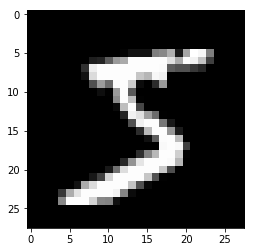

In [14]:
plt.imshow(x_train[0].reshape((28, 28)), cmap='gray')
x_train.shape

In [15]:
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid ))
n, c = x_train.shape
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

In [0]:
bs = 64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)

In [17]:
x, y = next(iter(data.train_dl))
x.shape, y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [0]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True)
        
    def forward(self, xb):
        return self.lin(xb)

In [0]:
model = Mnist_Logistic().cuda()

In [20]:
model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [21]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [22]:
model(x).shape

torch.Size([64, 10])

In [23]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

In [0]:
lr = 3e-2

In [0]:
loss_func = nn.CrossEntropyLoss()

In [0]:
def update(x, y, lr):
    wd = 1e-5
    y_hat = model(x)
    w2 = 0.
    for p in model.parameters():
        w2 += (p**2).sum()
    loss = loss_func(y_hat, y) + w2 * wd
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr*p.grad)
            p.grad.zero_()
    return loss.item()

In [0]:
losses = [update(x,y,lr) for x,y in data.train_dl]

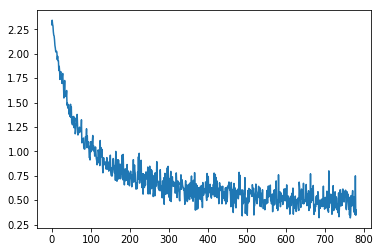

In [28]:
plt.plot(losses);

In [0]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)
        
    def forward(self, xb):
        xb = self.lin1(xb)
        xb = F.relu(xb)
        return self.lin2(xb)

In [0]:
model = Mnist_NN().cuda()

In [0]:
losses = [update(x,y,lr) for x,y in data.train_dl]

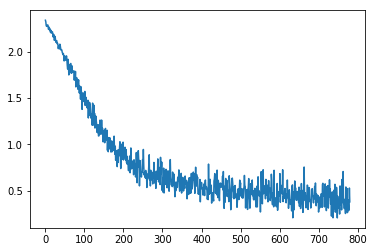

In [37]:
plt.plot(losses);

In [0]:
model = Mnist_NN().cuda()

In [0]:
def update(x, y, lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [0]:
losses = [update(x,y,1e-3) for x,y in data.train_dl]

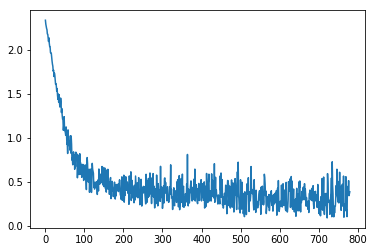

In [41]:
plt.plot(losses);

In [0]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

In [43]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


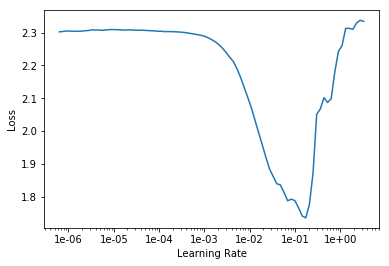

In [44]:
learn.recorder.plot()

In [45]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.158495,0.131912,0.961800,00:04


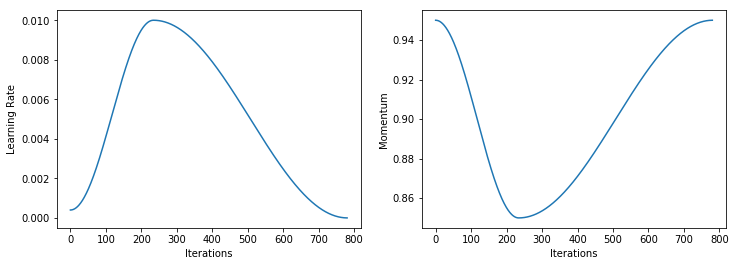

In [46]:
learn.recorder.plot_lr(show_moms=True)

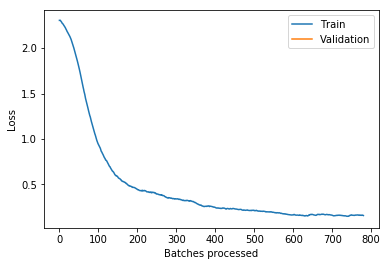

In [47]:
learn.recorder.plot_losses()

In [48]:
learn.fit_one_cycle(1, 3e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.144682,0.140714,0.960000,00:05
